# Auditing with AIF360 


## What is ML? 

![ML flow](https://rhodyprog4ds.github.io/BrownSpring23/_images/MLdataflow.svg)

In [1]:
import pandas as pd
from sklearn import metrics as skmetrics
from aif360 import metrics as fairmetrics
from aif360.datasets import BinaryLabelDataset
import seaborn as sns

compas_clean_url = 'https://raw.githubusercontent.com/ml4sts/outreach-compas/main/data/compas_c.csv'
compas_df = pd.read_csv(compas_clean_url,index_col = 'id')

compas_df = pd.get_dummies(compas_df,columns=['score_text'],)

We may get a warning which is **okay**. If you run the cell again it will go away.

## The COMPAS data

We are going to continue with the ProPublica COMPAS audit data.  Remember it contains: 
* `age`: defendant's age
* `c_charge_degree`: degree charged (Misdemeanor of Felony)
* `race`: defendant's race
* `age_cat`: defendant's age quantized in "less than 25", "25-45", or "over 45"
* `score_text`: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
* `sex`: defendant's gender
* `priors_count`: number of prior charges
* `days_b_screening_arrest`: number of days between charge date and arrest where defendant was screened for compas score
* `decile_score`: COMPAS score from 1 to 10 (low risk to high risk)
* `is_recid`: if the defendant recidivized
* `two_year_recid`: if the defendant within two years
* `c_jail_in`: date defendant was imprisoned
* `c_jail_out`: date defendant was released from jail
* `length_of_stay`: length of jail stay

First, we will look at it

In [2]:
compas_df.head()

,age,c_charge_degree,race,age_cat,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,length_of_stay,score_text_High,score_text_Low,score_text_Medium
id,,,,,,,,,,,,,,,,
3,34,F,African-American,25 - 45,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10,0,1,0
4,24,F,African-American,Less than 25,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,1,0
8,41,F,Caucasian,25 - 45,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6,0,0,1
10,39,M,Caucasian,25 - 45,Female,0,-1.0,1,0,0,2014-03-15 05:35:34,2014-03-18 04:28:46,2,0,1,0
14,27,F,Caucasian,25 - 45,Male,0,-1.0,4,0,0,2013-11-25 06:31:06,2013-11-26 08:26:57,1,0,1,0


Notice the last three columns.  When we use `pd.getdummies` with its `columns` parameter, then we can append the columns all at once and they get the original column name prepended to the value in the new column name.

We use the `two_year_recid` as the basis of our audit because it is the real outcome that the designers of COMPAS were hoping to predict.  Sicne the COMPAS score is on a scale of 1-10, we transform to a binary variable by thresholding it (eg all above t are 1, below are 0).  We use the `score_text` instead of `decile_score` in our thresholding so that we use a recommended threshold. 


More common is to use medium or high to check accuracy (or not low) we can calulate tihs by either summing two or inverting

let's do it by inverting here

In [3]:
int_not = lambda a:int(not(a))
compas_df['score_text_MedHigh'] = compas_df['score_text_Low'].apply(int_not)

Let's review computing the accruacy with sklearn:

In [4]:
skmetrics.accuracy_score(compas_df['two_year_recid'],
                         compas_df['score_text_High'])

0.6288366805608185

In [5]:
skmetrics.accuracy_score(compas_df['two_year_recid'],
                         compas_df['score_text_MedHigh'])

0.6582038651004168

## What about breaking it down by race?

Recall, we used groupby to get the per race score by creating a `lambda` function that we could apply to the groupby object.

In [6]:
compas_race = compas_df.groupby('race')

We can apply our method to each part of the  groupby object with `apply`

In [7]:
acc_fx = lambda d: skmetrics.accuracy_score(d['two_year_recid'],
                         d['score_text_MedHigh'])

compas_race.apply(acc_fx,).reset_index().rename(columns={0:'accuracy'})

,race,accuracy
0,African-American,0.649134
1,Caucasian,0.671897


## ML Notation

We use standard notation in machine learning, and in fair machine learning speicfically. 

This is important because we want to be able to communicate,like we call the horizontal and vertical axes of a plot the `x` and `y` axes. 

The AIF 360 pacakge we are about to use and sklearn both use this notation. 

-  _target_ or _labels_, denoted by for one sample (row) $i$ $\mathbf{y_i}$.
- whole column of the target variable is $Y$
- "hat" notation for predictions/ output of prediction algorithm $\hat{y}_i$ and $\hat{Y}$
- "protected attribute" $a_i$ and $A$

we use lowercase for one sample and uppercase for many.

In [8]:
help(skmetrics.accuracy_score)

Help on function accuracy_score in module sklearn.metrics._classification:

accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
    Accuracy classification score.
    
    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.
    
    Read more in the :ref:`User Guide <accuracy_score>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.
    
    normalize : bool, default=True
        If ``False``, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    Ret

## Using AIF360

The AIF360 package implements fairness metrics, some of which are derived from metrics we have seen and some others. [the documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html#aif360.metrics.ClassificationMetric) has the full list in a summary table with English explanations and details with most equations.



However, it has a few requirements:
- its constructor takes two `BinaryLabelDataset` objects
- these objects must be the same except for the label column
- the constructor for `BinaryLabelDataset` only accepts all numerical DataFrames


So, we have some preparation to do.  


First, we'll make a numerical copy of the `compas_df` columns that we need. The only nonnumerical column that we need is race, wo we'll make a `dict` to replace that/

We need to used numerical values for the protected attribute. so lets make a mapping value

In [9]:
race_num_map = {r:i for i,r, in enumerate(compas_df['race'].value_counts().index)}
race_num_map

{'African-American': 0, 'Caucasian': 1}

In [10]:
compas_df['race'].replace(race_num_map)

id
3        0
4        0
8        1
10       1
14       1
        ..
10994    0
10995    0
10996    0
10997    0
11000    0
Name: race, Length: 5278, dtype: int64

We will also only use a few of the variables.

In [11]:
required_cols = ['race','two_year_recid','score_text_MedHigh']
num_compas = compas_df[required_cols].replace(race_num_map)
num_compas.head(2)

,race,two_year_recid,score_text_MedHigh
id,,,
3,0,1,0
4,0,1,0


The scoring object requires that we have special data structures that wrap a DataFrame. 

We need one aif360 binary labeled dataset for the true values and one for the predictions. 
++

Next we will make two versions, one with race & the ground truth and ht eother with race & the predictions. It's easiest to drop the column we don't want.

The difference between the two datasets needs to be only the label column, so we drop the other variable from each small dataframe that we create.

In [12]:
num_compas_true = num_compas.drop(columns=['score_text_MedHigh'])
num_compas_pred = num_compas.drop(columns=['two_year_recid'])

Now we make the [`BinaryLabelDataset`](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset) objects, this type comes from AIF360 too.  Basically, it is a DataFrame with extra attributes; some specific and some inherited from [`StructuredDataset`](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.StructuredDataset.html#aif360.datasets.StructuredDataset).


````{margin}
```{note}
remember, you can inspect *any* object using the `__dict__` attribute
```
````

In [13]:
# here we want actual favorable outcome
broward_true = BinaryLabelDataset(favorable_label=0,unfavorable_label=1,
                                  df = num_compas_true,
                   label_names= ['two_year_recid'],
                  protected_attribute_names=['race'])
compas_predictions = BinaryLabelDataset(favorable_label=0,unfavorable_label=1,
                                        df = num_compas_pred,
                   label_names= ['score_text_MedHigh'],
                  protected_attribute_names=['race'])

This type also has an `ignore_fields` column for when comparisons are made, since the requirement is that only the *content* of the label column is different, but in our case also the label names are different, we have to tell it that that's okay.

In [14]:
# beacuse our columsn are named differently, we have to ignore that
compas_predictions.ignore_fields.add('label_names')
broward_true.ignore_fields.add('label_names')

In [15]:
compas_fair_scorer = fairmetrics.ClassificationMetric(broward_true,
                                                      compas_predictions,
                                 unprivileged_groups=[{'race':0}],
                                privileged_groups = [{'race':1}])

Now we can use the scores

In [16]:
compas_fair_scorer.accuracy()

0.6582038651004168

By default, we get the overall accuracy.  This calculation matches what we got using sklearn. 



For the aif360 metrics, they have one parameter, `privleged` with a defautl value of `None` when it's none it computes th ewhole dataset.  When `True` it compues only the priveleged group.

In [17]:
compas_fair_scorer.accuracy(True)

0.6718972895863052

Here that is Caucasion people.

When `False` it's the unpriveleged group, here African American

In [18]:
compas_fair_scorer.accuracy(False)

0.6491338582677165

These again match what we calculated before, the advantaged group (White) for True and disadvantaged group (Black) for False

In [19]:
compas_fair_scorer.error_rate_difference()

0.02276343131858871

the error rate alone does not tell the whole story because there are two types of errors. Plus there are even more ways we can think about if something is fair or not.

### Disparate Impact 

One way we might want to be fair is if the same % of each group of people (Black, $A=0$ and White,$A=1$) get the favorable outcome (a low score). 


In Disparate Impact the ratio is of the positive outcome, independent of the predictor.  So this is the ratio of the % of Black people not rearrested to % of white people rearrested.



$$D = \frac{\Pr(\hat{Y} = 1|A=0)}{\Pr(\hat{Y} =1|A=1)}$$

This is equivalent to saying that the score is unrelated to race.

This type of fair is often the kind that most people think of intuitively. It is like dividing things equally.

In [20]:
compas_fair_scorer.disparate_impact()

0.6336457196581771

US court doctrine says that this quantity has to be above .8 for employment decisions.  Does COMPAS pass this criterion?

## Equalized Odds Fairness

The journalists were concerned with the types of errors.  They accepted that it is not the creators of COMPAS fault that Black people get arrested at higher rates (though actual crime rates are equal; Black neighborhoods tend to be overpoliced). They wanted to consider what actually happened and then see how COMPAS did within each group.

In [21]:
compas_fair_scorer.false_positive_rate(True)

0.49635036496350365

In [22]:
compas_fair_scorer.false_positive_rate(False)

0.2847682119205298

false positives are incorrectly got a low score.  

This is different from how the problem was setup when we used sklearn because sklearn assumes tht 0 is the negative class and 1 is the "positive" class, but AIF360 lets us declre the favorable outcome(positive class) and unfavorable outcome (negative class)

White people were given a low score and then re-arrested almost twice as often as Black people.

Black people were given a low score and then re-arrested only a little more than half as often as white people.  (White people were give an low score and rearrested almost twice as often)

To make a single metric, we might take a ratio.  This is where the journalists [found bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing).

In [23]:
compas_fair_scorer.false_positive_rate_ratio()

0.5737241916634204

This metric would be fair with a value of 1.

got a high score and did not re-arrested  as a percentage of those who got a high score 


We can look at the other type of error

In [24]:
compas_fair_scorer.false_negative_rate(True)

0.22014051522248243

In [25]:
compas_fair_scorer.false_negative_rate(False)

0.4233817701453104

In [26]:
compas_fair_scorer.false_negative_rate_ratio()

1.9232342111919953

Black people were given a high score and not rearrested almost twice as often as white people.

So while the accuracy was similar (see error rate ratio) for Black and White people; the algorithm makes the opposite types of errors.

### Average Odds Difference

This is a combines the two errors we looked at separately into a single metric.  

$$ \tfrac{1}{2}\left[(FPR_{A = \text{unprivileged}} - FPR_{A = \text{privileged}})
   + (TPR_{A = \text{unprivileged}} - TPR_{A = \text{privileged}}))\right]$$

In [27]:
compas_fair_scorer.average_odds_difference()

-0.2074117039829009

**note** if time, discuss: 
- What should this look like if it is fair?
- what could this metric hide?

After the journalists published the piece, the people who made COMPAS countered with a technical report, arguing that that the journalists had measured fairness incorrectly.

The journalists two measures false positive rate and false negative rate use the true outcomes as the denominator.  

## Sufficiency and Calibration

The [COMPAS creators argued](https://www.equivant.com/response-to-propublica-demonstrating-accuracy-equity-and-predictive-parity/) that the model should be evaluated in terms of if a given score means the same thing across races; using the prediction as the denominator.

We can look at their preferred metrics too

In [28]:
compas_fair_scorer.false_omission_rate(True)

0.4051724137931034

In [29]:
compas_fair_scorer.false_omission_rate(False)

0.35046473482777474

In [30]:
compas_fair_scorer.false_omission_rate_ratio()

0.8649767923408909

In [31]:
compas_fair_scorer.false_discovery_rate_ratio()

1.2118532033913119

On these two metrics, the ratio is closer to 1 and much less disparate.


The creators thought it was important for the score to mean the same thing for every person assigned a score. The journalists thought it was more important for the algorithm to have the same impact of different groups of people.  
Ideally, we would like the score to both mean the same thing for different people and to have the same impact.

Researchers established that these are mutually exclusive, provably.  We cannot have both, so it is very important to think about what the performance metrics mean and how your algorithm will be used in order to choose how to prepare a model.  We will train models starting next week, but knowing these goals in advance is essential.

Importantly, this is not a statistical, computational choice that data can answer for us. This is about *human* values (and to some extent the law; certain domains have legal protections that require a specific condition).

The Fair Machine Learning book's classification Chapter has a [section on relationships between criteria](https://fairmlbook.org/classification.html#relationships-between-criteria) with the proofs.

To put it all together, we can make a plot. First we'll make a DataFrame

In [32]:
ratios = [{'score':compas_fair_scorer.false_omission_rate_ratio(),
          'name': 'false ommission rate',
          'group':'sufficiency',
          'preferred_by':'COMPAS'},
         {'score':compas_fair_scorer.false_discovery_rate_ratio(),
          'name': 'false discovery rate',
          'group':'sufficiency',
          'preferred_by':'COMPAS'},
         {'score':compas_fair_scorer.false_positive_rate_ratio(),
          'name': 'false positive rate',
          'group':'separation',
          'preferred_by':'ProPublica'},
         {'score':compas_fair_scorer.false_negative_rate_ratio(),
          'name': 'false negative rate',
          'group':'separation',
          'preferred_by':'ProPublica'}]
ratio_df = pd.DataFrame(ratios)
ratio_df

,score,name,group,preferred_by
0,0.864977,false ommission rate,sufficiency,COMPAS
1,1.211853,false discovery rate,sufficiency,COMPAS
2,0.573724,false positive rate,separation,ProPublica
3,1.923234,false negative rate,separation,ProPublica


In [33]:
%matplotlib inline

<AxesSubplot:xlabel='name', ylabel='score'>

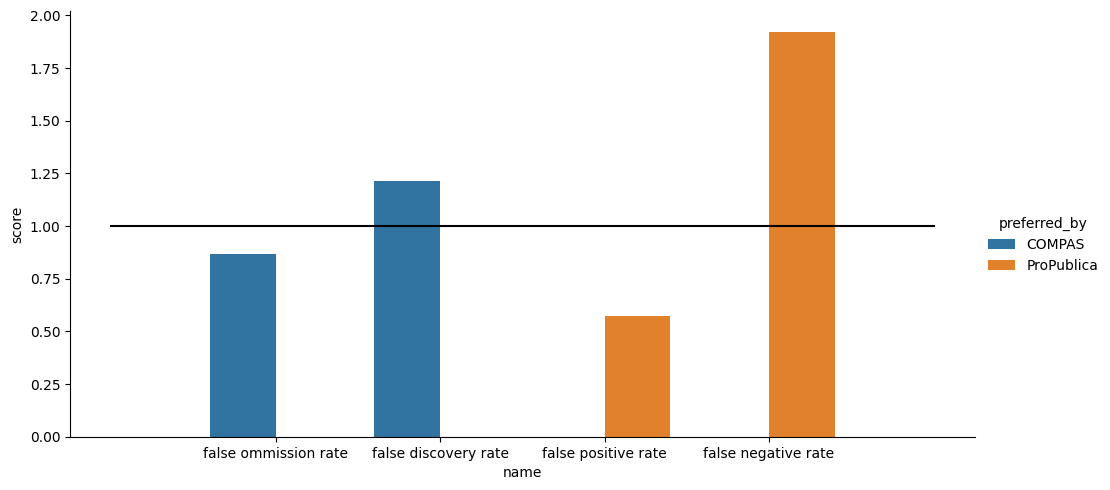

In [34]:
sns.catplot(data=ratio_df,y='score',x='name',hue='preferred_by',
           kind='bar',aspect=2)
sns.lineplot(x = [-1,4],y=[1,1],color='black',legend=False)

These are all ratios, so 1 is fair. COMPAS does okay on the measures it was designed around and poorly on the ones the journalists preferred.

In [35]:
compas_fair_scorer.false_omission_rate_difference()

-0.05470767896532869

In [36]:
compas_fair_scorer.false_discovery_rate_ratio()

1.2118532033913119